**IMPORTING MODULES**

In [18]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers

**DEFINING DATA**

In [23]:
hotel_data = pd.read_csv("./hotel.csv")
hotel_data.columns

X = hotel_data.copy()
y = hotel_data.pop("is_canceled")

features_num = [  'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']
features_cat = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date']

transformer_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (transformer_num,features_num),
    (transformer_cat,features_cat)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

shape = [X_train.shape[1]]

<Axes: title={'center': 'Accuracy'}>

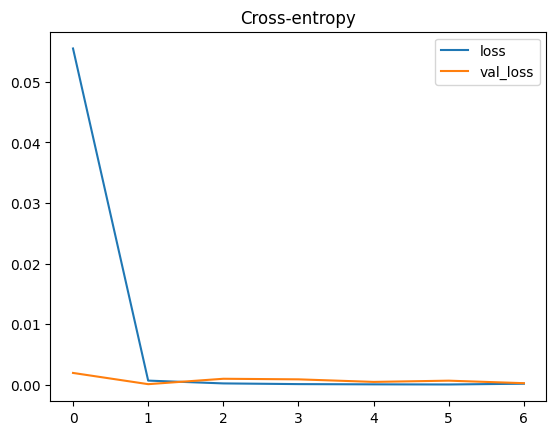

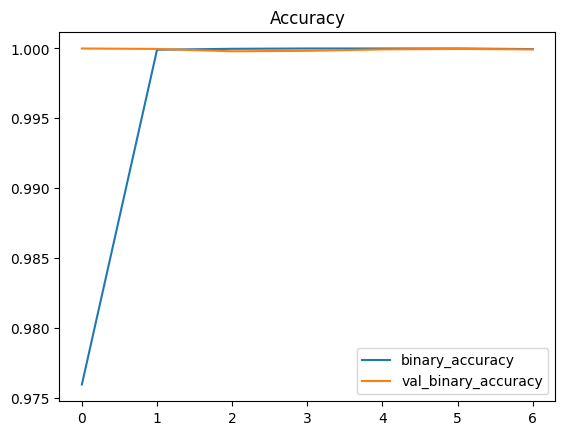

In [25]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation = 'softplus'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation = 'softplus'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1,activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(patience=5, min_delta=0.001,restore_best_weights=True)

history = model.fit(
    X_train,y_train,
    validation_data = (X_test,y_test),
    batch_size=256,
    epochs=50,
    callbacks = [early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")